In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D



# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from skopt import BayesSearchCV

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Utilities
import warnings
warnings.filterwarnings("ignore")


In [16]:
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


### **TASK 1: EXPLORATORY DATA ANALYSIS**

We will display different graphs that show interesting features put together in order to understand their relationship

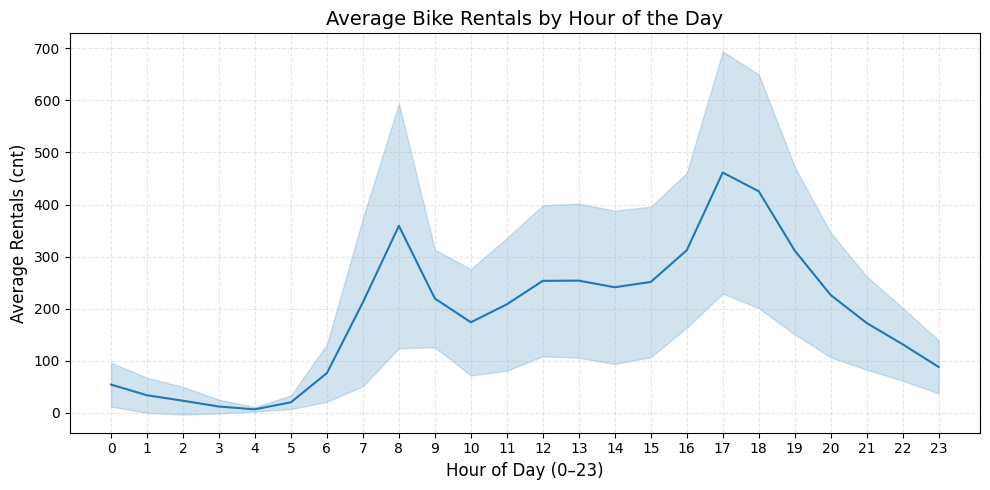

In [5]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x="hr", y="cnt", ci="sd")
plt.title("Average Bike Rentals by Hour of the Day", fontsize=14)
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Average Rentals (cnt)", fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


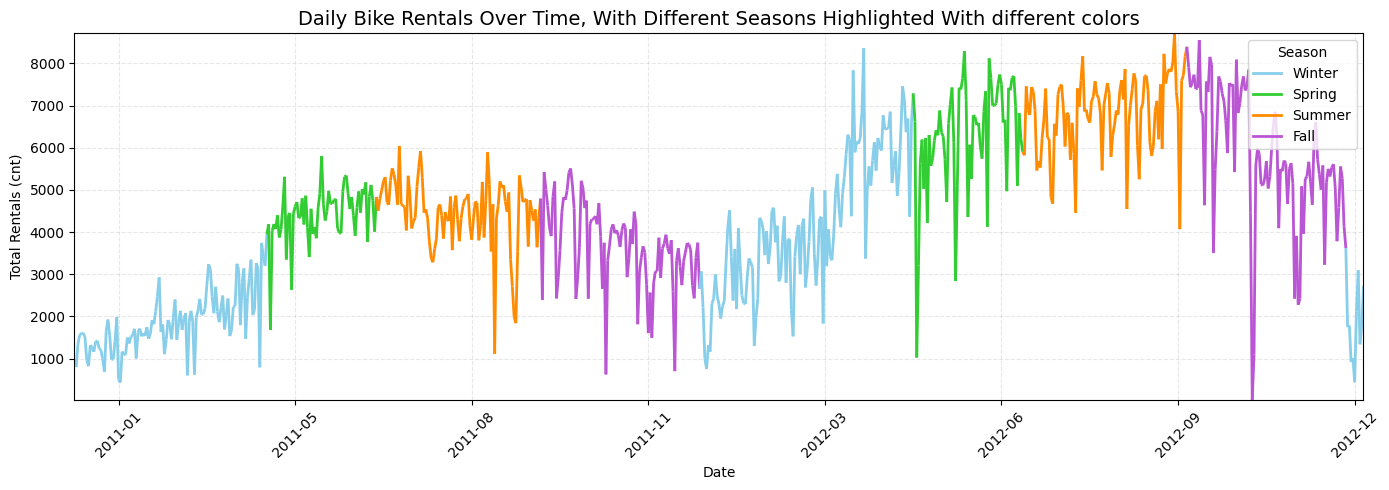

In [ ]:
# Create the daily df again (if not already)
df["dteday"] = pd.to_datetime(df["dteday"])
daily = df.groupby("dteday")["cnt"].sum().reset_index()

# Assign real season labels
def assign_season(date):
    y = date.year
    if pd.Timestamp(f"{y}-04-20") <= date < pd.Timestamp(f"{y}-06-21"):
        return "Spring"
    elif pd.Timestamp(f"{y}-06-21") <= date < pd.Timestamp(f"{y}-09-22"):
        return "Summer"
    elif pd.Timestamp(f"{y}-09-22") <= date < pd.Timestamp(f"{y}-12-21"):
        return "Fall"
    else:
        return "Winter"

daily["season"] = daily["dteday"].apply(assign_season)

# Prepare segments for coloring
dates = mdates.date2num(daily["dteday"])
points = np.array([dates, daily["cnt"]]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Map season to color
season_colors = {"Spring": "limegreen", "Summer": "darkorange", "Fall": "mediumorchid", "Winter": "skyblue"}
season_labels = daily["season"].values[:-1]
colors = [season_colors[s] for s in season_labels]

# Build the colored line
lc = LineCollection(segments, colors=colors, linewidth=2)

# Plot it
fig, ax = plt.subplots(figsize=(14, 5))
ax.add_collection(lc)
ax.set_xlim(dates.min(), dates.max())
ax.set_ylim(daily["cnt"].min(), daily["cnt"].max())
ax.set_title("Daily Bike Rentals Over Time, With Different Seasons Highlighted With different colors", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Total Rentals (cnt)")
ax.grid(True, linestyle="--", alpha=0.3)

# Format x-axis as dates
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.tight_layout()

# Format date axis
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

# Legend

legend_elements = [
    Line2D([0], [0], color="skyblue", lw=2, label="Winter"),
    Line2D([0], [0], color="limegreen", lw=2, label="Spring"),
    Line2D([0], [0], color="darkorange", lw=2, label="Summer"),
    Line2D([0], [0], color="mediumorchid", lw=2, label="Fall")
]
ax.legend(handles=legend_elements, title="Season")

plt.tight_layout()
plt.show()


